In [ ]:
# Clear all variables and reset the environment
%reset -f
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#A Model of Endogenous Housing and Labor Costs

##Theoretical Model

Housing cost depends on demand (sales) and construction cost:

\begin{equation}
HousingCost_{it} = \beta_1 + \beta_2 \cdot Sales_{it} + \beta_3 \cdot ConstructionCost_{it} + \epsilon^H_{it} \tag{1}
\end{equation}

Constuction cost, in turn, depends on material prices and labor cost:


\begin{equation}
ConstructionCost_{it} = \alpha_1 + \alpha_2 \cdot MaterialPrices_{it} + \alpha_3 \cdot LaborCosts_{it} + \epsilon^C_{it} \tag{2}
\end{equation}

Labor costs depend on housing costs:

\begin{equation}
LaborCosts_{it} = \gamma_1 + \gamma_2 \cdot HousingCost_{it} + \epsilon^L_{it}
\tag{3}
\end{equation}

The system of simultaneous population regression equations hypothesizes that housing cost in geography $i$ during time period $t$ depends on construction costs and the number of homes sold (Sales) in that geography and time period. Construction costs in turn depend on material prices and labor costs (e.g., wages), and finally labor costs depends of housing cost as laborers will reuire higher wages in geographies and times with higher housing costs.

We can use substitution to show how the construction cost equation depends on housing cost:

\begin{equation}
ConstructionCost_{it} = \alpha_1 + \alpha_2 \cdot MaterialPrices_{it} +\alpha_3 \cdot (\gamma_1 + \gamma_2 \cdot HousingCost_{it} + \epsilon^L_{it}) + \epsilon^C_{it}
\tag{2a}
\end{equation}

If we substituted the original housing equation (1) into (2a), then we could solve for construction cost and show $COV(ConstructionCost_{it},\epsilon^C_{it}) \neq 0$. Note that material prices and sales are **exogenous** to the system as written.

In order to create the endogenous housing data, we need to simulate the entire system by substituting (2a) into (1):

\begin{multline}
HousingCost_{it} = \beta_1 + \beta_2Sales_{it}\\
+ \beta_3\left[\alpha_1 + \alpha_2 MaterialPrices_{it} + \alpha_3(\gamma_1 + \gamma_2 HousingCost_{it} + \epsilon^L_{it})\right]\\ + \epsilon^H_{it} \tag{1a}
\end{multline}

 If the dependent variable shows up on the right-hand side of the regression equation, we definitely have an endogeneity issue! Once we solve for housing cost, we'll be ready to implement a simulation.

\begin{equation}
HousingCost_{it} = \frac{\beta_1 + \beta_3\alpha_1 + \beta_3\alpha_3\gamma_1 + \beta_2Sales_{it}+\beta_3\alpha_2MaterialPrices_{it} + \beta_3\alpha_3\epsilon^L_{it}+\epsilon^H}{1-\beta_3\alpha_3\gamma_2} \tag{1b}
\end{equation}

Equation (1b) expresses housing cost as a function of only exogenous variables and error terms. However, the parameters in (1b) will also appear when the endogenous variables, labor costs and construction costs, are generated. This will introduce the endogeneiety to the construction costs in the original housing cost equation (1).

In [ ]:
#### Parameters for simulation ####
np.random.seed(27)
n = 5000

# Equation 1 – Housing Cost
beta1 = 50      # Intercept (thousands of $USD; represents "land cost")
beta2 = 0.5     # Effect of sales (higher during booms; assumed exogenous for simulation)
beta3 = 1       # Effect of construction cost (parameter of interest)

# Equation 2 – Construction Cost
alpha1 = 0      # Intercept (no fixed cost)
alpha2 = 1      # Effect of material prices
alpha3 = 0.5    # Effect of labor cost

# Equation 3 – Labor Cost
gamma1 = 1      # Intercept
gamma2 = 0.5    # Effect of housing cost on labor cost (endogenous feedback)

# Generate exogenous variables and error terms (created outside the system)
sales = np.random.normal(100, 30, n)           # Sales (exogenous)
material_prices = np.random.normal(50, 10, n)  # Material prices (exogenous)

# Error terms
epsilon_h = np.random.normal(0, 10, n)  # Housing cost error
epsilon_c = np.random.normal(0, 10, n)  # Construction cost error
epsilon_l = np.random.normal(0, 10, n)  # Labor cost error

# Generate housing cost using exogenous variables and error terms
housing_cost = (
    beta1 + beta3*alpha1 + beta3*alpha3*gamma1
    + beta2*sales + beta3*alpha2*material_prices
    + beta3*alpha3*epsilon_l + epsilon_h
) / (1 - beta3*alpha3*gamma2)

# Generate endogenous independent variables
labor_cost = gamma1 + gamma2*housing_cost + epsilon_l
construction_cost = alpha1 + alpha2*material_prices + alpha3*labor_cost + epsilon_c

# Run OLS on Equation (1) and examine the construction cost coefficient
X_ols = sm.add_constant(np.column_stack([sales, construction_cost]))  # Regressors: sales and construction cost
ols_model = sm.OLS(housing_cost, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     8254.
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:25:13   Log-Likelihood:                -20178.
No. Observations:                5000   AIC:                         4.036e+04
Df Residuals:                    4997   BIC:                         4.038e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.9122      1.117     59.006      0.0

In [ ]:
# 2SLS using material_prices as an instrument for construction_cost

# First stage: predict construction_cost from instrument(s) + control(s)
# (material_prices is the instrument; sales is included as a control)
X_material_prices = sm.add_constant(np.column_stack([material_prices, sales]))
ols_construction_cost_model = sm.OLS(construction_cost, X_material_prices).fit()

# Get fitted values of construction_cost from the first stage
fitted_construction_cost = ols_construction_cost_model.fittedvalues

# Second stage: regress housing_cost on sales + fitted construction_cost
X_housing_cost = sm.add_constant(np.column_stack([sales, fitted_construction_cost]))
ols_housing_cost_model = sm.OLS(housing_cost, X_housing_cost).fit()

# Print summaries for both stages
print("First stage OLS: construction_cost ~ 1 + material_prices + sales")
print(ols_construction_cost_model.summary())

print("\nSecond stage OLS (2SLS step 2): housing_cost ~ 1 + sales + fitted_construction_cost")
print(ols_housing_cost_model.summary())


First stage OLS: construction_cost ~ 1 + material_prices + sales
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     3396.
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:25:13   Log-Likelihood:                -19629.
No. Observations:                5000   AIC:                         3.926e+04
Df Residuals:                    4997   BIC:                         3.928e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

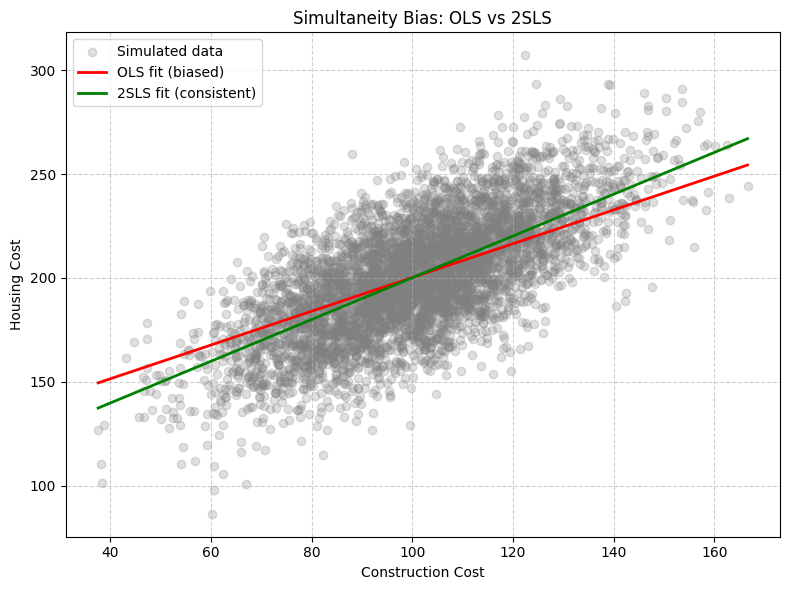

In [ ]:
# --- Hold sales constant (e.g., at the mean) ---
sales_mean = np.mean(sales)

# --- Create a reasonable range of construction costs based on the data ---
x_min, x_max = construction_cost.min(), construction_cost.max()
x_grid = np.linspace(x_min, x_max, 200)

# --- Predicted housing_cost using OLS coefficients ---
b0, b_sales, b_const = ols_model.params
yhat_ols = b0 + b_sales * sales_mean + b_const * x_grid

# --- Predicted housing_cost using 2SLS coefficients ---
b0_iv, b_sales_iv, b_const_iv = ols_housing_cost_model.params
yhat_iv = b0_iv + b_sales_iv * sales_mean + b_const_iv * x_grid

# --- Plot OLS and 2SLS fits over the simulated data ---
plt.figure(figsize=(8, 6))
plt.scatter(construction_cost, housing_cost, alpha=0.25, color="gray", label="Simulated data")
plt.plot(x_grid, yhat_ols, color="red", linewidth=2, label="OLS fit (biased)")
plt.plot(x_grid, yhat_iv, color="green", linewidth=2, label="2SLS fit (consistent)")
plt.xlabel("Construction Cost")
plt.ylabel("Housing Cost")
plt.title("Simultaneity Bias: OLS vs 2SLS")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#From 2SLS to Two-Stage Machine Learning
We can use flexible machine learning models for the first stage. The goal is still to isolate variation in the endogenous regressors that is exogenous.
The key is to avoid overfitting that would naturally result from this in the first stage. Overfitting the first-stage model will likely violate the exogeneity assumption. One fix for this is "cross-fitting" the data:

1. Split sample into folds.
2. Estimate the first stage and outcome models on one fold.
3. Predict on the held out fold to create the predicted values for the second stage.
4. Repeat on other folds and combine the results to get predictions for all observations.

There are trade-offs because two-stage machine learning will involve more of a black box rather than theory-based exogeneity.

In [ ]:
# --- 1) First-stage model: Random Forest Regression ---
rf = RandomForestRegressor(
    n_estimators=400,      # number of trees in the forest (higher = smoother average)
    random_state=27,       # ensures reproducibility (so results don't change each run)
    min_samples_leaf=5,    # prevents overfitting by forcing each leaf to have ≥5 observations
    n_jobs=-1              # use all available CPU cores to run faster
)

# --- 2) 2-fold cross-fitting setup ---
n = len(housing_cost)
idx = np.arange(n)
np.random.shuffle(idx)     # randomize order of observations
fold_A = idx[: n//2]       # first half of data (Fold A)
fold_B = idx[n//2 :]       # second half (Fold B)

# Features for first stage: instrument(s) + control(s)
X_features = np.column_stack([material_prices, sales])

# --- Train on A, predict for B (out-of-sample) ---
rf.fit(X_features[fold_A], construction_cost[fold_A])
construction_hat_B = rf.predict(X_features[fold_B])

# --- Train on B, predict for A (out-of-sample) ---
rf.fit(X_features[fold_B], construction_cost[fold_B])
construction_hat_A = rf.predict(X_features[fold_A])

# Combine out-of-fold predictions (keeps all predictions "honest" and out-of-sample)
construction_hat_cf = np.empty_like(construction_cost, dtype=float)
construction_hat_cf[fold_A] = construction_hat_A
construction_hat_cf[fold_B] = construction_hat_B

# --- 3) First-stage fit check ---
first_stage_r2 = r2_score(construction_cost, construction_hat_cf)
# This R² is calculated using only out-of-sample predictions,
# so it reflects the instrument’s predictive strength *without* overfitting.

# --- 4) Second-stage regression ---
# Regress housing_cost on sales and the instrumented construction_cost
X_second_stage = sm.add_constant(np.column_stack([sales, construction_hat_cf]))
sml_model = sm.OLS(housing_cost, X_second_stage).fit(cov_type="HC1")
# HC1 = heteroskedasticity-consistent robust standard errors

# --- 5) Print results for classroom discussion ---
print("=== Two-Stage Machine Learning (2SML, Random Forest, 2-fold cross-fitting) ===")
print(f"Coefficient on instrumented construction_cost: {sml_model.params[-1]:.4f}")
print(f"Robust SE (HC1): {sml_model.bse[-1]:.4f}")
print(f"First-stage out-of-sample R^2: {first_stage_r2:.3f}")

=== Two-Stage Machine Learning (2SML, Random Forest, 2-fold cross-fitting) ===
Coefficient on instrumented construction_cost: 0.9224
Robust SE (HC1): 0.0159
First-stage out-of-sample R^2: 0.527
